# Introduction

This notebook will analyze California housing data and aim to model the prices of houses in California based on age, location, and other factors. The data that we will be using is presents information of California's housing districts. Thus, you will see information based on the median or total population, income, or bedrooms per housing district (not per home).

# Imports

In [1]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import plotly as py
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

# Load the Data

In [2]:
##Downloading the data

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path=os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
##Loading the data
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

# Data Exploration

Before we split the data into training, validation, and test sets, let's get an understanding of what type of data we are dealing with and what distribution they fall into.

In [5]:
##Exploring the data
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

Here we can see that types of features that we will be working with. Many of these are continuous, such as income or house value, whereas others are discrete, such as, ocean proximity. Ocean proximity is our only categorical feature. Likely because it is a representation of distances, we can replace it with ordinal encodings.

Median House Value is scaled down by 1,000 (so whatever you see in that column can be multiplied by 1,000 to get its true value).

In [6]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

As we can see in this table, we are missing values for total bedrooms. Likely we will replace this either for the mean, the local mean (for housing districts in close vicinity), or the mode.

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

**Distributions**

Below I am plotting histograms for each attribute so that we can learn characteristics of each attribute's distribution. Bbecause each attribute doesn't fall into a gaussian distribution, bucketing or slicing may need to be used.




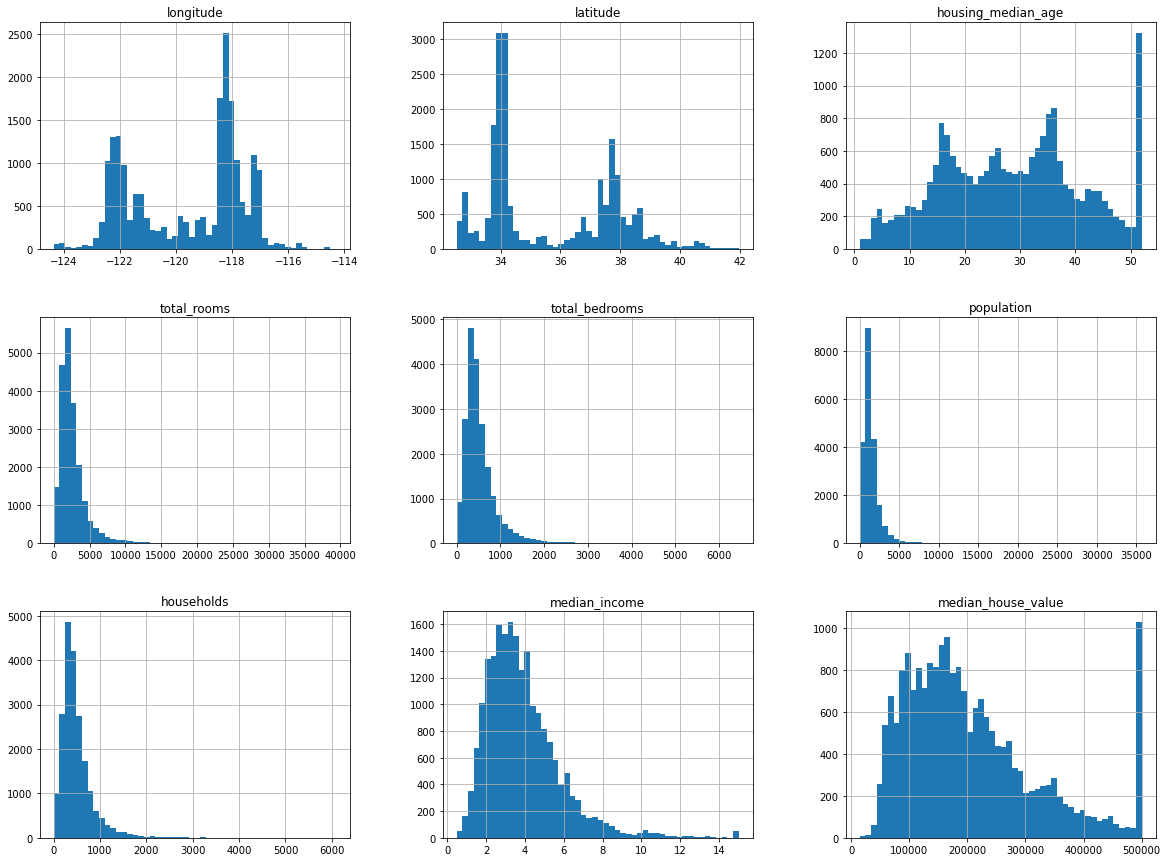

In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Longitude and latitude appear to follow Bernoulli distributions (left peak or right peak, but not much in between), housing median age seems to follow approximately a normal distribution, and the rest appear to follow a 
log normal distribution.

# Splitting Our Data

In [10]:
housing.corr()

longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924664           -0.108197     0.044568   
latitude            -0.924664  1.000000            0.011173    -0.036100   
housing_median_age  -0.108197  0.011173            1.000000    -0.361262   
total_rooms          0.044568 -0.036100           -0.361262     1.000000   
total_bedrooms       0.069608 -0.066983           -0.320451     0.930380   
population           0.099773 -0.108785           -0.296244     0.857126   
households           0.055310 -0.071035           -0.302916     0.918484   
median_income       -0.015176 -0.079809           -0.119034     0.198050   
median_house_value  -0.045967 -0.144160            0.105623     0.134153   

                    total_bedrooms  population  households  median_income  \
longitude                 0.069608    0.099773    0.055310      -0.015176   
latitude                 -0.066983   -0.108785   -0.071035      -0.079809   
housing_median_age       -0.320451   -0.296244   -0.302916      -0.119034   
total_rooms               0.930380    0.857126    0.918484       0.198050   
total_bedrooms            1.000000    0.877747    0.979728      -0.007723   
population                0.877747    1.000000    0.907222       0.004834   
households                0.979728    0.907222    1.000000       0.013033   
median_income            -0.007723    0.004834    0.013033       1.000000   
median_house_value        0.049686   -0.024650    0.065843       0.688075   

                    median_house_value  
longitude                    -0.045967  
latitude                     -0.144160  
housing_median_age            0.105623  
total_rooms                   0.134153  
total_bedrooms                0.049686  
population                   -0.024650  
households                    0.065843  
median_income                 0.688075  
median_house_value            1.000000

As you can see from the above correlation matrix, median_income is highly correlated to median_house_value. To make sure that our data is IID (independent and identically distributed) we will split our training, validation, and test data into sets with equal levels of each level of income. 

First we will bucketize it and then use stratified split to split up our dataset.

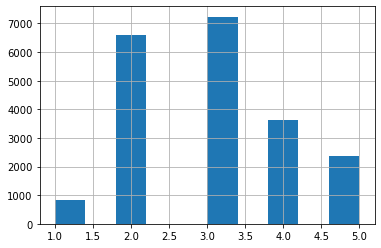

In [11]:
housing['income_cat'] = pd.cut(housing['median_income'],
                              bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels = [1, 2, 3, 4, 5])
housing['income_cat'].hist()

In [12]:
#I DO NOT THINK WE USE THIS, COMMENTING TO SEE IF IT EFFECTS CODE
###splitting test set from training set
#def split_train_test(data, test_ratio):
#    shuffled_indices = np.random.permutation(len(data))
#    test_set_size = int(len(data) * test_ratio)
#    test_indices = shuffled_indices[:test_set_size]
#    train_indices = shuffled_indices[test_set_size:]
#    return data.iloc[test_indices], data.iloc[train_indices]

In [13]:
#I DO NOT THINK WE USE THIS, COMMENTING TO SEE IF IT EFFECTS CODE
#train_set, test_set = split_train_test(housing, 0.2)
#print(len(train_set))
#print(len(test_set))

In [14]:
##splitting the training and test sets based on the bucket of income that each district fits in
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)
for train_val_index, test_index, in split.split(housing, housing['income_cat']):
    strat_train_val_set = housing.loc[train_val_index]
    strat_test_set = housing.loc[test_index]

Below I check the percentage of each bucket to see if it matches the percentage present in the larger dataset. You can see the percentage present in the larger dataset is nearly identical.



In [15]:
print('Test set percentage distribution:', strat_test_set['income_cat'].value_counts()/len(strat_test_set))
print('Train/Validation set percentage distribution:', strat_train_val_set['income_cat'].value_counts()/len(strat_train_val_set))
print('Original percentage distribution:', housing['income_cat'].value_counts()/len(housing))

Test set percentage distribution: 3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64
Train/Validation set percentage distribution: 3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64
Original percentage distribution: 3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64


Now I will split the training/validation set into separate train and valiation sets.

In [16]:
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)
for train_index, val_index, in split.split(strat_train_val_set, strat_train_val_set['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_val_set = housing.loc[val_index]

Again, notice the percentage distribution present in the training and validation sets.

In [17]:
print('Train set percentage distribution:', strat_train_set['income_cat'].value_counts()/len(strat_train_set))
print('Validation set percentage distribution:', strat_val_set['income_cat'].value_counts()/len(strat_val_set))

Train set percentage distribution: 3    0.354455
2    0.328791
4    0.167689
5    0.106670
1    0.042395
Name: income_cat, dtype: float64
Validation set percentage distribution: 3    0.359673
2    0.328792
4    0.154708
5    0.111111
1    0.045716
Name: income_cat, dtype: float64


In [18]:
#dropping the income_cat column so that you don't get modeled predictions that are overly accurate
for set_ in (strat_train_set, strat_val_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

# Adjusting Distributions

To correct for log normal distributions, we will take the log of their values and will be left with a normal distribution. Below I have added the log of their values to the data frame. As you can see each graph that used to have a left skew now follows a normal distribution.

In [19]:
strat_train_set['log_rooms'] = np.log(strat_train_set.total_rooms.values)
strat_train_set['log_bedrooms'] = np.log(strat_train_set.total_bedrooms.values)
strat_train_set['log_population'] = np.log(strat_train_set.population.values)
strat_train_set['log_households'] = np.log(strat_train_set.households.values)
strat_train_set['log_median_income'] = np.log(strat_train_set.median_income.values)

Also, let's look at the difference when we standardize our features.

In [20]:
std_scaler = StandardScaler()
strat_train_set['scaled_longitude'] = std_scaler.fit_transform(strat_train_set['longitude'].values.reshape(-1,1))
strat_train_set['scaled_latitude'] = std_scaler.fit_transform(strat_train_set['latitude'].values.reshape(-1,1))
strat_train_set['scaled_housing_median_age'] = std_scaler.fit_transform(strat_train_set['housing_median_age'].values.reshape(-1,1))
strat_train_set['scaled_total_rooms'] = std_scaler.fit_transform(strat_train_set['total_rooms'].values.reshape(-1,1))
strat_train_set['scaled_total_bedrooms'] = std_scaler.fit_transform(strat_train_set['total_bedrooms'].values.reshape(-1,1))
strat_train_set['scaled_population'] = std_scaler.fit_transform(strat_train_set['population'].values.reshape(-1,1))
strat_train_set['scaled_households'] = std_scaler.fit_transform(strat_train_set['households'].values.reshape(-1,1))
strat_train_set['scaled_median_income'] = std_scaler.fit_transform(strat_train_set['median_income'].values.reshape(-1,1))
strat_train_set['scaled_log_rooms'] = std_scaler.fit_transform(strat_train_set['log_rooms'].values.reshape(-1,1))
strat_train_set['scaled_log_bedrooms'] = std_scaler.fit_transform(strat_train_set['log_bedrooms'].values.reshape(-1,1))
strat_train_set['scaled_log_population'] = std_scaler.fit_transform(strat_train_set['log_population'].values.reshape(-1,1))
strat_train_set['scaled_log_households'] = std_scaler.fit_transform(strat_train_set['log_households'].values.reshape(-1,1))
strat_train_set['scaled_log_median_income'] = std_scaler.fit_transform(strat_train_set['log_median_income'].values.reshape(-1,1))

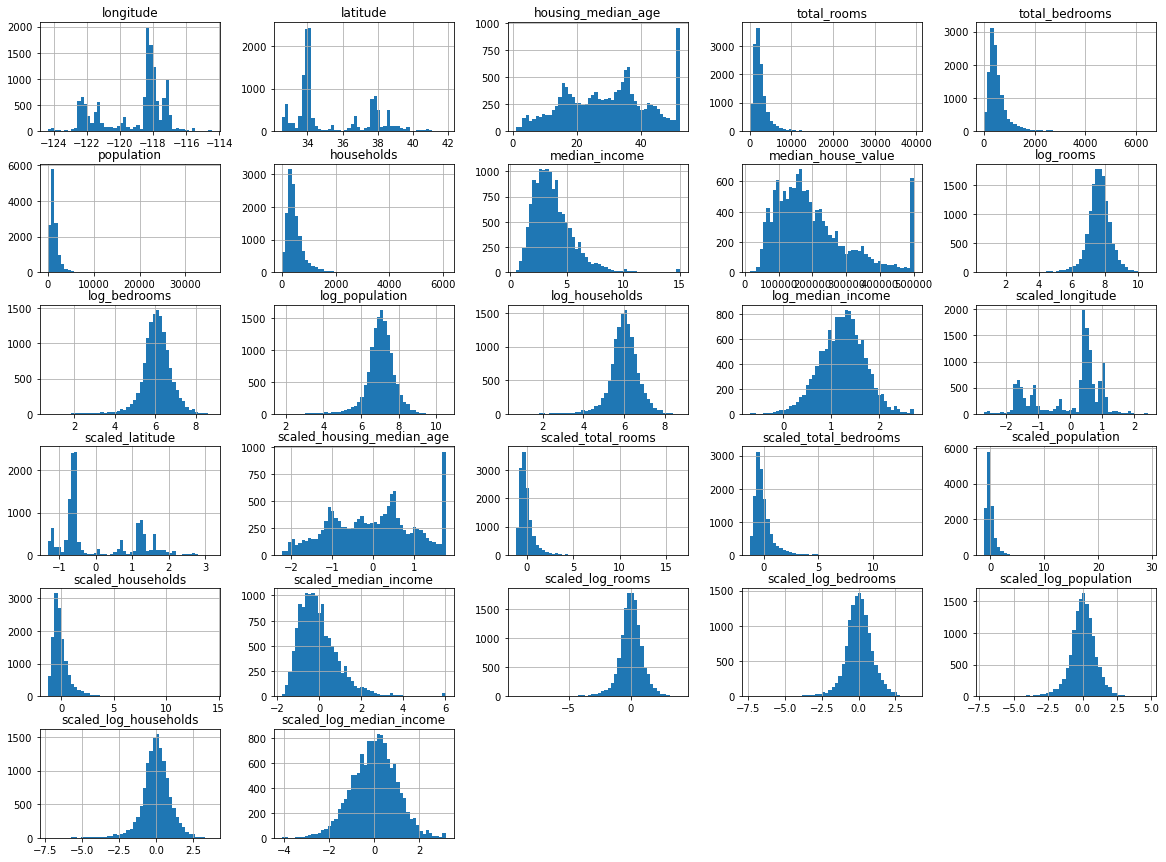

In [21]:
%matplotlib inline 
strat_train_set.hist(bins=50, figsize=(20,15))
plt.show()

You can see above how our log features follow normal distributions, and how our scaled features have a mean of 0 and standard deviation of 1 (they have been standardized).

**Removing Outliers**

Further, we can prepare our data by getting rid of outliers that lay beyond 3 standard deviations away from the mean so that our model does not overfit to outliers. To be sure that this is beneficial for the performance of our model, we can see what accuracy scores we get with and without our outliers (although likely we will leave median income alone as it is so highly correlated to median house value).

Below we create a new data fram that mirrors our stratified train set, but just has the outliers removed. We can use this to tell independently of our normal training set if we could benefit from removing outliers (which our model likely would).

In [22]:
out_strat_train_set=strat_train_set.copy()
for column in out_strat_train_set.columns[10:14]:
    mean = np.mean(out_strat_train_set[column])
    std = np.std(out_strat_train_set[column])
    out_strat_train_set = out_strat_train_set[(out_strat_train_set[column]< 3*std+mean) & (out_strat_train_set[column]>(-3*std+mean))]

In [23]:
px.histogram(strat_train_set['total_rooms'], x='total_rooms', title='Original Distribution of Total Rooms')

In [24]:
px.histogram(strat_train_set['log_rooms'], x='log_rooms', title='Normalized Distribution of Total Rooms', color_discrete_sequence=['purple'])

In [25]:
px.histogram(out_strat_train_set['log_rooms'], x='log_rooms', title='Normalized Distribution of Total Rooms with Outliers Removed', color_discrete_sequence=['red'])

You can see the effect on the data distribution by normalizing and removing outliers.

# Feature Engineering

Below we see a visual of a location of these housing districts. You can notice by the size of the circles the population in these areas, and by the color the median house value.

Notice that there are hot spots, where median house value is much higher around big cities in California, such as San Francisco, Los Angeles, and San Diego.

In [26]:
fig = px.scatter(strat_train_set, x='longitude', y='latitude', size=strat_train_set['population']/100, color='median_house_value')
fig

In [27]:
corr_matrix = strat_train_set.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value           1.000000
scaled_median_income         0.668046
median_income                0.668046
scaled_log_median_income     0.631529
log_median_income            0.631529
log_rooms                    0.168058
scaled_log_rooms             0.168058
scaled_total_rooms           0.134231
total_rooms                  0.134231
scaled_housing_median_age    0.112534
housing_median_age           0.112534
log_households               0.086627
scaled_log_households        0.086627
scaled_households            0.072531
households                   0.072531
scaled_log_bedrooms          0.070011
log_bedrooms                 0.070011
total_bedrooms               0.058454
scaled_total_bedrooms        0.058454
longitude                    0.019294
scaled_longitude             0.019294
scaled_log_population       -0.024727
log_population              -0.024727
scaled_population           -0.030220
population                  -0.030220
latitude                    -0.178389
scaled_latit

Based on this correlation matrix, likely we will benefit from training on latitude, housing median age, total rooms (or log total rooms), and median income (or log median income).

For comparison we can train on both the features we deem to be important in one trial, as well as all features in another trial.

Below we will add a few synthetic features:
1. Rooms per household
2. Bedrooms per room
3. Population per household

In [28]:
strat_train_set['rooms_per_household'] = strat_train_set['total_rooms']/strat_train_set['households']
strat_train_set['bedrooms_per_room'] = strat_train_set['total_bedrooms']/strat_train_set['total_rooms']
strat_train_set['population_per_household'] = strat_train_set['population']/strat_train_set['households']

Let's see how well these synthetic features correlate to our labels.

In [29]:
corr_matrix = strat_train_set.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value           1.000000
scaled_median_income         0.668046
median_income                0.668046
scaled_log_median_income     0.631529
log_median_income            0.631529
log_rooms                    0.168058
scaled_log_rooms             0.168058
scaled_total_rooms           0.134231
total_rooms                  0.134231
rooms_per_household          0.130993
scaled_housing_median_age    0.112534
housing_median_age           0.112534
log_households               0.086627
scaled_log_households        0.086627
scaled_households            0.072531
households                   0.072531
scaled_log_bedrooms          0.070011
log_bedrooms                 0.070011
total_bedrooms               0.058454
scaled_total_bedrooms        0.058454
longitude                    0.019294
scaled_longitude             0.019294
scaled_log_population       -0.024727
log_population              -0.024727
scaled_population           -0.030220
population                  -0.030220
population_p

Rooms per household and bedrooms per room seem to be good indicators of median house value. Notice that negative values also are good indicators of correlation because negative proportionality means that as those features get greater, the target will diminish (or visa versa).

In [30]:
strat_val_set

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
3012     -118.95     34.83                18.0       3278.0           762.0   
6966     -118.06     33.99                45.0       1471.0           255.0   
13328    -117.66     34.05                 6.0       5129.0          1119.0   
163      -122.25     37.81                46.0       3232.0           835.0   
782      -122.13     37.66                19.0        862.0           167.0   
...          ...       ...                 ...          ...             ...   
8305     -118.12     33.76                45.0       3035.0           516.0   
13372    -117.51     34.14                21.0       2455.0           381.0   
13662    -117.32     34.03                13.0       3853.0           761.0   
1795     -122.34     37.93                30.0       2515.0           481.0   
14256    -117.11     32.71                30.0       1729.0           457.0   

       population  households  median_income  median_house_value  \
3012       1338.0       550.0         2.9891            116500.0   
6966        670.0       250.0         4.5478            188000.0   
13328      2533.0       949.0         3.6250            113600.0   
163        1373.0       747.0         3.2250            218800.0   
782         407.0       183.0         4.3456            163000.0   
...           ...         ...            ...                 ...   
8305       1127.0       527.0         7.0796            500001.0   
13372      1094.0       327.0         4.6437            191700.0   
13662      1685.0       669.0         3.9024            122400.0   
1795       1327.0       428.0         2.1287             95000.0   
14256      1673.0       460.0         1.7000             85900.0   

      ocean_proximity  
3012           INLAND  
6966        <1H OCEAN  
13328          INLAND  
163          NEAR BAY  
782          NEAR BAY  
...               ...  
8305       NEAR OCEAN  
13372          INLAND  
13662          INLAND  
1795         NEAR BAY  
14256      NEAR OCEAN  

[3303 rows x 10 columns]

**Dropping Labels**

In [31]:
#starting with a clean copy copying the stratified training set
#dropping the labels so they don't corrupt training
#**the drop feature creates a copy so that the stratified training set isn't effected
strat_train_set_labels=strat_train_set['median_house_value'].copy()
strat_train_set = strat_train_set.drop('median_house_value', axis=1)
#doing the same for the validation and test sets
strat_val_set_labels=strat_val_set['median_house_value'].copy()
strat_val_set = strat_val_set.drop('median_house_value', axis=1)
strat_test_set_labels=strat_test_set['median_house_value'].copy()
strat_test_set = strat_test_set.drop('median_house_value', axis=1)

# Preparing and Transforming Data

We will start by handling our numerical values. To do this we will create a set of only numerical values (we will drop our one categorical value), then we will fill empty spaces in our date with an imputer. We can confidently impute values based on the mean, because our data follows a standard distribution. 

In [32]:
imputer = SimpleImputer(strategy='mean')
#a numerical-only copy of the dataset is needed to impute based on median
#here we drop categorical attributes
strat_train_set_num = strat_train_set.drop('ocean_proximity', axis=1)
imputer.fit(strat_train_set_num)

SimpleImputer()

In [33]:
imputer.statistics_

array([-1.19137526e+02,  3.52590143e+01,  2.93409039e+01,  2.63002067e+03,
        5.43050547e+02,  1.43891279e+03,  5.03219547e+02,  3.80047443e+00,
        7.62455707e+00,  6.05988437e+00,  7.03352478e+00,  5.98830044e+00,
        1.22701077e+00,  5.79612232e-15, -6.67293712e-16,  1.02205405e-17,
       -2.15169274e-18,  6.30289496e-17,  5.37923186e-17,  6.67024750e-17,
       -1.50080569e-16, -3.72780768e-16, -9.09029592e-16, -4.52931322e-16,
       -1.08122560e-15, -9.41365575e-17,  5.39091925e+00,  2.16033442e-01,
        3.00070892e+00])

In [34]:
#the .fit function found the medians, but did not transform the numerical data
strat_train_set_num.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  13209.000000  13209.000000        13209.000000  13209.000000   
mean    -119.137526     35.259014           29.340904   2630.020668   
std        1.924682      2.092296           12.767127   2230.470379   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.240000     33.860000           19.000000   1438.000000   
50%     -118.300000     34.090000           30.000000   2105.000000   
75%     -117.890000     37.700000           38.000000   3107.000000   
max     -114.470000     41.880000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    13077.000000  13209.000000  13209.000000   13209.000000   
mean       543.050547   1438.912787    503.219547       3.800474   
std        431.074710   1173.838827    389.751432       1.863173   
min          2.000000      6.000000      2.000000       0.499900   
25%        297.000000    792.000000    280.000000       2.526300   
50%        435.000000   1169.000000    410.000000       3.486100   
75%        648.000000   1728.000000    603.000000       4.650000   
max       6445.000000  35682.000000   6082.000000      15.000100   

          log_rooms  log_bedrooms  ...  scaled_households  \
count  13209.000000  13077.000000  ...       1.320900e+04   
mean       7.624557      6.059884  ...       1.343967e-16   
std        0.747430      0.727448  ...       1.000038e+00   
min        0.693147      0.693147  ...      -1.286047e+00   
25%        7.271009      5.693732  ...      -5.727445e-01   
50%        7.652071      6.075346  ...      -2.391860e-01   
75%        8.041413      6.473891  ...       2.560202e-01   
max       10.579489      8.771060  ...       1.431423e+01   

       scaled_median_income  scaled_log_rooms  scaled_log_bedrooms  \
count          1.320900e+04      1.320900e+04         1.307700e+04   
mean          -1.670966e-16     -3.648296e-16        -8.560866e-16   
std            1.000038e+00      1.000038e+00         1.000038e+00   
min           -1.771547e+00     -9.274015e+00        -7.377767e+00   
25%           -6.838992e-01     -4.730371e-01        -5.033572e-01   
50%           -1.687370e-01      3.681246e-02         2.125548e-02   
75%            4.559736e-01      5.577404e-01         5.691433e-01   
max            6.011276e+00      3.953608e+00         3.727111e+00   

       scaled_log_population  scaled_log_households  scaled_log_median_income  \
count           1.320900e+04           1.320900e+04              1.320900e+04   
mean           -4.367684e-16          -1.103810e-15             -1.054687e-16   
std             1.000038e+00           1.000038e+00              1.000038e+00   
min            -7.166876e+00          -7.295596e+00             -4.102402e+00   
25%            -4.907977e-01          -4.870628e-01             -6.414256e-01   
50%             4.153636e-02           3.838063e-02              4.651270e-02   
75%             5.758849e-01           5.698760e-01              6.619369e-01   
max             4.715525e+00           3.754179e+00              3.163914e+00   

       rooms_per_household  bedrooms_per_room  population_per_household  
count         13209.000000       13077.000000              13209.000000  
mean              5.390919           0.216033                  3.000709  
std               2.767118           0.060071                  5.336988  
min               0.846154           0.100000                  0.692308  
25%               4.374368           0.176892                  2.427027  
50%               5.161663           0.205801                  2.831683  
75%               5.986111           0.243538                  3.313433  
max             141.909091           1.000000                599.714286  

[8 rows x 29 columns]

In [35]:
#this actually transforms/imputes upon the numerical data
X = imputer.transform(strat_train_set_num)

In [36]:
X_tr = pd.DataFrame(X, columns=strat_train_set_num.columns,
                         index=strat_train_set_num.index)

In [37]:
X_tr.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  13209.000000  13209.000000        13209.000000  13209.000000   
mean    -119.137526     35.259014           29.340904   2630.020668   
std        1.924682      2.092296           12.767127   2230.470379   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.240000     33.860000           19.000000   1438.000000   
50%     -118.300000     34.090000           30.000000   2105.000000   
75%     -117.890000     37.700000           38.000000   3107.000000   
max     -114.470000     41.880000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    13209.000000  13209.000000  13209.000000   13209.000000   
mean       543.050547   1438.912787    503.219547       3.800474   
std        428.915233   1173.838827    389.751432       1.863173   
min          2.000000      6.000000      2.000000       0.499900   
25%        298.000000    792.000000    280.000000       2.526300   
50%        438.000000   1169.000000    410.000000       3.486100   
75%        645.000000   1728.000000    603.000000       4.650000   
max       6445.000000  35682.000000   6082.000000      15.000100   

          log_rooms  log_bedrooms  ...  scaled_households  \
count  13209.000000  13209.000000  ...       1.320900e+04   
mean       7.624557      6.059884  ...       1.343967e-16   
std        0.747430      0.723804  ...       1.000038e+00   
min        0.693147      0.693147  ...      -1.286047e+00   
25%        7.271009      5.697093  ...      -5.727445e-01   
50%        7.652071      6.066108  ...      -2.391860e-01   
75%        8.041413      6.469250  ...       2.560202e-01   
max       10.579489      8.771060  ...       1.431423e+01   

       scaled_median_income  scaled_log_rooms  scaled_log_bedrooms  \
count          1.320900e+04      1.320900e+04         1.320900e+04   
mean          -1.670966e-16     -3.648296e-16        -8.508936e-16   
std            1.000038e+00      1.000038e+00         9.950285e-01   
min           -1.771547e+00     -9.274015e+00        -7.377767e+00   
25%           -6.838992e-01     -4.730371e-01        -4.987363e-01   
50%           -1.687370e-01      3.681246e-02         8.555883e-03   
75%            4.559736e-01      5.577404e-01         5.627641e-01   
max            6.011276e+00      3.953608e+00         3.727111e+00   

       scaled_log_population  scaled_log_households  scaled_log_median_income  \
count           1.320900e+04           1.320900e+04              1.320900e+04   
mean           -4.367684e-16          -1.103810e-15             -1.054687e-16   
std             1.000038e+00           1.000038e+00              1.000038e+00   
min            -7.166876e+00          -7.295596e+00             -4.102402e+00   
25%            -4.907977e-01          -4.870628e-01             -6.414256e-01   
50%             4.153636e-02           3.838063e-02              4.651270e-02   
75%             5.758849e-01           5.698760e-01              6.619369e-01   
max             4.715525e+00           3.754179e+00              3.163914e+00   

       rooms_per_household  bedrooms_per_room  population_per_household  
count         13209.000000       13209.000000              13209.000000  
mean              5.390919           0.216033                  3.000709  
std               2.767118           0.059770                  5.336988  
min               0.846154           0.100000                  0.692308  
25%               4.374368           0.177286                  2.427027  
50%               5.161663           0.206278                  2.831683  
75%               5.986111           0.243026                  3.313433  
max             141.909091           1.000000                599.714286  

[8 rows x 29 columns]

Next we will handle our categorical values. In this case it is only the ocean proximity feature. To try to make the encoding more meaningful, I have arranged the values from low to high in order of how close the housing district is to the waterfront. Presumably proximity to the waterfront would make housing property more valuable, so I think that this feature will be very useful.

In [38]:
#imputing over categorical attributes
strat_train_set_cat = strat_train_set[['ocean_proximity']]
strat_train_set_cat.head(10)

ocean_proximity
12620          INLAND
3778        <1H OCEAN
7850        <1H OCEAN
10381       <1H OCEAN
1401         NEAR BAY
14198      NEAR OCEAN
8035        <1H OCEAN
7484        <1H OCEAN
2174           INLAND
5206        <1H OCEAN

In [39]:
strat_train_set_cat.shape

(13209, 1)

In [40]:
#converting these objects to numbers to work with them
ordinal_encoder = OrdinalEncoder(categories=[['ISLAND', 'NEAR OCEAN', 'NEAR BAY', '<1H OCEAN', 'INLAND']])
strat_train_set_cat_encoded = ordinal_encoder.fit_transform(strat_train_set_cat)
strat_train_set_cat_encoded[:10]

array([[4.],
       [3.],
       [3.],
       [3.],
       [2.],
       [1.],
       [3.],
       [3.],
       [4.],
       [3.]])

In [41]:
ordinal_encoder.categories_

[array(['ISLAND', 'NEAR OCEAN', 'NEAR BAY', '<1H OCEAN', 'INLAND'],
       dtype=object)]

In [42]:
#Custom Transformer
#creating a class for custom clean up operations and adding specific attributes
rooms_ix, bedrooms_ix, population_ix, households_ix, income_ix = 3, 4, 5, 6, 7
class log_function(BaseEstimator, TransformerMixin):
    def __init__(self, all=True): #no *args or **kargs
        self.all = all 
    def fit(self, X, y=None):
        return self #nothing else to do
    def transform(self, X):
        X=X.values
        log_rooms = np.log((X[:, rooms_ix] + 1e-7).astype(float))
        log_bedrooms = np.log((X[:, bedrooms_ix] + 1e-7).astype(float))
        log_population = np.log((X[:, population_ix] + 1e-7).astype(float))
        log_households = np.log((X[:, households_ix] + 1e-7).astype(float))
        log_income = np.log((X[:, households_ix] + 1e-7).astype(float))
        
        return np.c_[X[:,0:3], log_rooms, log_bedrooms, log_population, log_households, log_income]
log_func = log_function()
logged_attribs = log_func.transform(strat_val_set)


Showing that our new function works.

In [43]:
logged_attribs_df = pd.DataFrame(logged_attribs, columns=strat_val_set.columns[:-1],
                         index=strat_val_set.index)
logged_attribs_df

longitude latitude housing_median_age total_rooms total_bedrooms  \
3012    -118.95    34.83                 18     8.09499        6.63595   
6966    -118.06    33.99                 45      7.2937        5.54126   
13328   -117.66    34.05                  6     8.54267        7.02019   
163     -122.25    37.81                 46     8.08086        6.72743   
782     -122.13    37.66                 19     6.75926        5.11799   
...         ...      ...                ...         ...            ...   
8305    -118.12    33.76                 45     8.01797        6.24611   
13372   -117.51    34.14                 21     7.80588         5.9428   
13662   -117.32    34.03                 13     8.25661        6.63463   
1795    -122.34    37.93                 30     7.83003        6.17587   
14256   -117.11    32.71                 30      7.4553        6.12468   

      population households median_income  
3012     7.19893    6.30992       6.30992  
6966     6.50728    5.52146       5.52146  
13328    7.83716    6.85541       6.85541  
163      7.22475    6.61607       6.61607  
782      6.00881    5.20949       5.20949  
...          ...        ...           ...  
8305     7.02731     6.2672        6.2672  
13372     6.9976    5.78996       5.78996  
13662    7.42952    6.50578       6.50578  
1795     7.19068    6.05912       6.05912  
14256    7.42237    6.13123       6.13123  

[3303 rows x 8 columns]

In [44]:
strat_val_set

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
3012     -118.95     34.83                18.0       3278.0           762.0   
6966     -118.06     33.99                45.0       1471.0           255.0   
13328    -117.66     34.05                 6.0       5129.0          1119.0   
163      -122.25     37.81                46.0       3232.0           835.0   
782      -122.13     37.66                19.0        862.0           167.0   
...          ...       ...                 ...          ...             ...   
8305     -118.12     33.76                45.0       3035.0           516.0   
13372    -117.51     34.14                21.0       2455.0           381.0   
13662    -117.32     34.03                13.0       3853.0           761.0   
1795     -122.34     37.93                30.0       2515.0           481.0   
14256    -117.11     32.71                30.0       1729.0           457.0   

       population  households  median_income ocean_proximity  
3012       1338.0       550.0         2.9891          INLAND  
6966        670.0       250.0         4.5478       <1H OCEAN  
13328      2533.0       949.0         3.6250          INLAND  
163        1373.0       747.0         3.2250        NEAR BAY  
782         407.0       183.0         4.3456        NEAR BAY  
...           ...         ...            ...             ...  
8305       1127.0       527.0         7.0796      NEAR OCEAN  
13372      1094.0       327.0         4.6437          INLAND  
13662      1685.0       669.0         3.9024          INLAND  
1795       1327.0       428.0         2.1287        NEAR BAY  
14256      1673.0       460.0         1.7000      NEAR OCEAN  

[3303 rows x 9 columns]

In [45]:
#Custom Transformer
#creating a class to take the log of certain features
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): #no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self #nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attribs = attr_adder.transform(logged_attribs)


In [46]:
housing_extra_attribs

array([[-118.95, 34.83, 18.0, ..., 1.2828991441987785,
        1.1408913591474958, 0.8197598234050678],
       [-118.06, 33.99, 45.0, ..., 1.32097244346066, 1.1785427459988764,
        0.7597330953060122],
       [-117.66, 34.05, 6.0, ..., 1.246120579856544, 1.1432082141490718,
        0.8217798423523187],
       ...,
       [-117.32, 34.03, 13.0, ..., 1.2691179522948495,
        1.1419870032588622, 0.8035544238748874],
       [-122.34, 37.93, 30.0, ..., 1.2922708170022328,
        1.1867519114603244, 0.788741394690344],
       [-117.11, 32.71, 30.0, ..., 1.2159554859480108,
        1.2105854698917065, 0.821520882473986]], dtype=object)

In [47]:
#creating a pipeline for data transformations
#this pipeline makes use of the custom class, a standardization scaler and a numerical imputer
num_pipeline = Pipeline([
    ('log_func', log_function()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('attribs_adder', CombinedAttributesAdder(add_bedrooms_per_room=True)),
    ('std_scaler', StandardScaler())
])
strat_train_set_num_tr = num_pipeline.fit_transform(strat_train_set_num)

Making sure our numerical feature pipeline works.

In [48]:
strat_train_set_num_tr_df = pd.DataFrame(strat_train_set_num_tr, columns=strat_train_set_num.columns[:-18],
                         index=strat_train_set_num.index)
strat_train_set_num_tr_df

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12620  -1.243096  1.549067           -0.966652     0.549100    1.487091e-01   
3778    0.383208 -0.520507           -0.418348     1.513485    2.454289e-15   
7850    0.497517 -0.654337           -0.340019     1.414866    1.698098e+00   
10381   0.783289 -0.778607           -1.828272     0.540839    3.429430e-01   
1401   -1.523673  1.286188            0.756589     0.095265   -1.366154e-01   
...          ...       ...                 ...          ...             ...   
9340   -1.793857  1.305307            0.521601     1.158798    9.806310e-01   
10305   0.705352 -0.659116           -1.044981    -0.172618   -8.118718e-01   
2914    0.029890  0.048267           -1.358298     1.533363    1.323091e+00   
3713    0.383208 -0.506168            0.051626     0.207824    5.868537e-01   
3716    0.378012 -0.506168            0.208285     0.386625    5.847427e-01   

       population  households  median_income  log_rooms  log_bedrooms  \
12620    0.253470    0.297957       0.297957   0.171038     -0.208029   
3778     1.304834    1.818090       1.818090  -0.916703     -1.123731   
7850     1.773475    1.692487       1.692487  -0.861448     -0.326763   
10381   -0.192624    0.407596       0.407596  -0.024104     -1.074548   
1401    -0.138199   -0.048301      -0.048301   0.145121     -0.195060   
...           ...         ...            ...        ...           ...   
9340     0.704904    1.005102       1.005102  -0.178205     -0.724702   
10305   -0.360797   -0.734332      -0.734332   1.057748      0.798727   
2914     1.314549    1.388074       1.388074  -0.292736     -0.476558   
3713     0.766839    0.583518       0.583518  -0.745572      0.064331   
3716     0.911651    0.585778       0.585778  -0.515119      0.275087   

       log_population  
12620       -0.671475  
3778        -2.636379  
7850         1.201666  
10381       -0.200302  
1401        -0.489316  
...               ...  
9340         0.102197  
10305       -1.648069  
2914         0.175383  
3713         1.044722  
3716         0.673286  

[13209 rows x 11 columns]

In [49]:


cat_pipeline = Pipeline([
    ('encoder', OrdinalEncoder(categories=[['ISLAND', 'NEAR OCEAN', 'NEAR BAY', '<1H OCEAN', 'INLAND']]))
])

strat_train_set_cat_tr = cat_pipeline.fit_transform(strat_train_set_cat)

Making sure our categorical feature pipeline works.

In [50]:

strat_train_set_cat_tr_df = pd.DataFrame(strat_train_set_cat_tr, columns=strat_train_set_cat.columns,
                         index=strat_train_set_cat.index)
strat_train_set_cat_tr_df

ocean_proximity
12620              4.0
3778               3.0
7850               3.0
10381              3.0
1401               2.0
...                ...
9340               2.0
10305              3.0
2914               4.0
3713               3.0
3716               3.0

[13209 rows x 1 columns]

In [51]:
#creating pipeline to handle numerical and categorical date preprocessing
num_attribs = list(housing)[:-3]
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer ([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])


In [52]:
prepared_train_set = full_pipeline.fit_transform(strat_train_set)
prepared_val_set = full_pipeline.fit_transform(strat_val_set)

In [53]:
new_out_strat_train_set = out_strat_train_set.drop(['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                         'households', 'median_income', 'median_house_value', 'scaled_total_rooms',
                         'scaled_total_bedrooms', 'scaled_population', 'scaled_households', 
                         'scaled_median_income', 'log_rooms', 'log_population', 'log_households', 'log_bedrooms', 
                                                    'log_median_income', 'longitude', 'latitude'], axis = 1)
new_out_strat_train_set[['ocean_proximity']] = ordinal_encoder.fit_transform(new_out_strat_train_set[['ocean_proximity']])
new_out_strat_train_set



ocean_proximity  scaled_longitude  scaled_latitude  \
12620              4.0         -1.243096         1.549067   
7850               3.0          0.497517        -0.654337   
10381              3.0          0.783289        -0.778607   
1401               2.0         -1.523673         1.286188   
14198              1.0          1.100237        -1.218332   
...                ...               ...              ...   
9340               2.0         -1.793857         1.305307   
10305              3.0          0.705352        -0.659116   
2914               4.0          0.029890         0.048267   
3713               3.0          0.383208        -0.506168   
3716               3.0          0.378012        -0.506168   

       scaled_housing_median_age  scaled_log_rooms  scaled_log_bedrooms  \
12620                  -0.966652          0.549100             0.147964   
7850                   -0.340019          1.414866             1.689592   
10381                  -1.828272          0.540839             0.341225   
1401                    0.756589          0.095265            -0.135931   
14198                  -0.731665          0.912382             0.760908   
...                          ...               ...                  ...   
9340                    0.521601          1.158798             0.975719   
10305                  -1.044981         -0.172618            -0.807805   
2914                   -1.358298          1.533363             1.316463   
3713                    0.051626          0.207824             0.583914   
3716                    0.208285          0.386625             0.581814   

       scaled_log_population  scaled_log_households  scaled_log_median_income  
12620               0.253470               0.297957                  1.366476  
7850                1.773475               1.692487                 -0.519884  
10381              -0.192624               0.407596                  0.444959  
1401               -0.138199              -0.048301                  0.633867  
14198               1.269563               0.890509                  0.194754  
...                      ...                    ...                       ...  
9340                0.704904               1.005102                  0.427086  
10305              -0.360797              -0.734332                  1.431897  
2914                1.314549               1.388074                  0.629114  
3713                0.766839               0.583518                 -0.389574  
3716                0.911651               0.585778                  0.065000  

[12682 rows x 9 columns]

# Modeling the Data

As Ocean Proximity couldn't be examined in the same way as the numerical columns before, below we plot this column to see how it is correlated with housing value. While living on an island appears to be expensive housing, all of the other categories appear to be ubiquitous. This feature doesn't look very useful.

In [54]:
columns = strat_train_set_num.columns[:8] 
entry = ['rooms_per_household', 'population_per_household', 
              'bedrooms_per_room', 'ocean_proximity']
columns = np.append(columns, entry)
columns
prepared_train_set_df = pd.DataFrame(prepared_train_set, columns=columns,
                         index=strat_train_set.index)
px.scatter(x=prepared_train_set_df['ocean_proximity'], y=strat_train_set_labels)

**Data Selection**

Things we want to look at in choosing data are training on important features vs. training on all features (based on the correlation matrix we saw earlier), training with and without outliers, and training on features that appear important based on grid search performed on a model (GridSearchCV can output feature importances).

**Training on Important Features Vs. All Features**

Earlier we saw these features to be important:
* Median Income
* Total Rooms
* Rooms per Household
* Housing Median Age
* Bedrooms per Room
* Latitude
 
And these were not:
* Households
* Total Bedrooms
* Longitude
* Population
* Population per Household
* Ocean Proximity

In [55]:
columns = strat_train_set_num.columns[:8] 
entry = ['rooms_per_household', 'population_per_household', 
              'bedrooms_per_room', 'ocean_proximity']
columns = np.append(columns, entry)
columns

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'population_per_household',
       'bedrooms_per_room', 'ocean_proximity'], dtype=object)

In [56]:
prepared_train_set_df = pd.DataFrame(prepared_train_set, columns=columns,
                         index=strat_train_set.index)
prepared_val_set_df = pd.DataFrame(prepared_val_set, columns=columns,
                         index=strat_val_set.index)
prepared_train_set_df

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12620  -1.243096  1.549067           -0.966652     0.549100    1.487091e-01   
3778    0.383208 -0.520507           -0.418348     1.513485    2.454289e-15   
7850    0.497517 -0.654337           -0.340019     1.414866    1.698098e+00   
10381   0.783289 -0.778607           -1.828272     0.540839    3.429430e-01   
1401   -1.523673  1.286188            0.756589     0.095265   -1.366154e-01   
...          ...       ...                 ...          ...             ...   
9340   -1.793857  1.305307            0.521601     1.158798    9.806310e-01   
10305   0.705352 -0.659116           -1.044981    -0.172618   -8.118718e-01   
2914    0.029890  0.048267           -1.358298     1.533363    1.323091e+00   
3713    0.383208 -0.506168            0.051626     0.207824    5.868537e-01   
3716    0.378012 -0.506168            0.208285     0.386625    5.847427e-01   

       population  households  median_income  rooms_per_household  \
12620    0.253470    0.297957       0.297957             0.171038   
3778     1.304834    1.818090       1.818090            -0.916703   
7850     1.773475    1.692487       1.692487            -0.861448   
10381   -0.192624    0.407596       0.407596            -0.024104   
1401    -0.138199   -0.048301      -0.048301             0.145121   
...           ...         ...            ...                  ...   
9340     0.704904    1.005102       1.005102            -0.178205   
10305   -0.360797   -0.734332      -0.734332             1.057748   
2914     1.314549    1.388074       1.388074            -0.292736   
3713     0.766839    0.583518       0.583518            -0.745572   
3716     0.911651    0.585778       0.585778            -0.515119   

       population_per_household  bedrooms_per_room  ocean_proximity  
12620                 -0.208029          -0.671475              4.0  
3778                  -1.123731          -2.636379              3.0  
7850                  -0.326763           1.201666              3.0  
10381                 -1.074548          -0.200302              3.0  
1401                  -0.195060          -0.489316              2.0  
...                         ...                ...              ...  
9340                  -0.724702           0.102197              2.0  
10305                  0.798727          -1.648069              3.0  
2914                  -0.476558           0.175383              4.0  
3713                   0.064331           1.044722              3.0  
3716                   0.275087           0.673286              3.0  

[13209 rows x 12 columns]

In [57]:
unimportant_features = ['households', 'total_bedrooms', 'longitude', 'population', 'population_per_household', 'ocean_proximity']
feature_drop_train_set_df = prepared_train_set_df.drop(unimportant_features, axis=1)
feature_drop_val_set_df = prepared_val_set_df.drop(unimportant_features, axis=1)
feature_drop_train_set_df

latitude  housing_median_age  total_rooms  median_income  \
12620  1.549067           -0.966652     0.549100       0.297957   
3778  -0.520507           -0.418348     1.513485       1.818090   
7850  -0.654337           -0.340019     1.414866       1.692487   
10381 -0.778607           -1.828272     0.540839       0.407596   
1401   1.286188            0.756589     0.095265      -0.048301   
...         ...                 ...          ...            ...   
9340   1.305307            0.521601     1.158798       1.005102   
10305 -0.659116           -1.044981    -0.172618      -0.734332   
2914   0.048267           -1.358298     1.533363       1.388074   
3713  -0.506168            0.051626     0.207824       0.583518   
3716  -0.506168            0.208285     0.386625       0.585778   

       rooms_per_household  bedrooms_per_room  
12620             0.171038          -0.671475  
3778             -0.916703          -2.636379  
7850             -0.861448           1.201666  
10381            -0.024104          -0.200302  
1401              0.145121          -0.489316  
...                    ...                ...  
9340             -0.178205           0.102197  
10305             1.057748          -1.648069  
2914             -0.292736           0.175383  
3713             -0.745572           1.044722  
3716             -0.515119           0.673286  

[13209 rows x 6 columns]

In [58]:
feature_drop_train_set = feature_drop_train_set_df.to_numpy()
feature_drop_val_set = feature_drop_val_set_df.to_numpy()
feature_drop_train_set.shape

(13209, 6)

Perfect! Now we are ready to compare these two side by side.

In [59]:
forest_reg = RandomForestRegressor()
forest_reg.fit(prepared_train_set, strat_train_set_labels)
preds = forest_reg.predict(prepared_val_set)
loss = mean_absolute_error(strat_val_set_labels, preds)
print('Training on all the features yields a loss of', loss)

Training on all the features yields a loss of 56556.38815016652


In [60]:
forest_reg = RandomForestRegressor()
forest_reg.fit(feature_drop_train_set, strat_train_set_labels)
preds = forest_reg.predict(feature_drop_val_set)
loss = mean_absolute_error(strat_val_set_labels, preds)
print('Training on only the important features yields a loss of', loss)

Training on only the important features yields a loss of 65636.33222827733


So it looks like our model actually benefits from the added data the less important features offer.

**Training with and without Outliers**

In [61]:
#Building an outlier-free training set
no_outliers_prepared_train_set_df = prepared_train_set_df.copy()
no_outliers_prepared_train_set_df
for column in no_outliers_prepared_train_set_df.columns[2:-1]:
    mean = np.mean(no_outliers_prepared_train_set_df[column])
    std = np.std(no_outliers_prepared_train_set_df[column])
    no_outliers_prepared_train_set_df = no_outliers_prepared_train_set_df[(no_outliers_prepared_train_set_df[column]< 3*std+mean) & (no_outliers_prepared_train_set_df[column]>(-3*std-mean))]
no_outliers_prepared_train_set = no_outliers_prepared_train_set_df.to_numpy()
#also adjusting the labels for this outlier-free training set
no_outliers_prepared_train_set_labels = strat_train_set_labels[no_outliers_prepared_train_set_df.index]
no_outliers_prepared_train_set_df

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12620  -1.243096  1.549067           -0.966652     0.549100        0.148709   
7850    0.497517 -0.654337           -0.340019     1.414866        1.698098   
10381   0.783289 -0.778607           -1.828272     0.540839        0.342943   
1401   -1.523673  1.286188            0.756589     0.095265       -0.136615   
14198   1.100237 -1.218332           -0.731665     0.912382        0.764739   
...          ...       ...                 ...          ...             ...   
9340   -1.793857  1.305307            0.521601     1.158798        0.980631   
10305   0.705352 -0.659116           -1.044981    -0.172618       -0.811872   
2914    0.029890  0.048267           -1.358298     1.533363        1.323091   
3713    0.383208 -0.506168            0.051626     0.207824        0.586854   
3716    0.378012 -0.506168            0.208285     0.386625        0.584743   

       population  households  median_income  rooms_per_household  \
12620    0.253470    0.297957       0.297957             0.171038   
7850     1.773475    1.692487       1.692487            -0.861448   
10381   -0.192624    0.407596       0.407596            -0.024104   
1401    -0.138199   -0.048301      -0.048301             0.145121   
14198    1.269563    0.890509       0.890509            -0.311976   
...           ...         ...            ...                  ...   
9340     0.704904    1.005102       1.005102            -0.178205   
10305   -0.360797   -0.734332      -0.734332             1.057748   
2914     1.314549    1.388074       1.388074            -0.292736   
3713     0.766839    0.583518       0.583518            -0.745572   
3716     0.911651    0.585778       0.585778            -0.515119   

       population_per_household  bedrooms_per_room  ocean_proximity  
12620                 -0.208029          -0.671475              4.0  
7850                  -0.326763           1.201666              3.0  
10381                 -1.074548          -0.200302              3.0  
1401                  -0.195060          -0.489316              2.0  
14198                  0.267680           0.072686              1.0  
...                         ...                ...              ...  
9340                  -0.724702           0.102197              2.0  
10305                  0.798727          -1.648069              3.0  
2914                  -0.476558           0.175383              4.0  
3713                   0.064331           1.044722              3.0  
3716                   0.275087           0.673286              3.0  

[12542 rows x 12 columns]

Great! Now we can compare side by side the results of removing outliers versus leaving them in.

In [62]:
forest_reg = RandomForestRegressor()
forest_reg.fit(prepared_train_set, strat_train_set_labels)
preds = forest_reg.predict(prepared_val_set)
loss = mean_absolute_error(strat_val_set_labels, preds)
print('Training on all the data including outliers yields a loss of', loss)

Training on all the data including outliers yields a loss of 57392.26084468664


In [63]:
forest_reg = RandomForestRegressor()
forest_reg.fit(no_outliers_prepared_train_set, no_outliers_prepared_train_set_labels)
preds = forest_reg.predict(prepared_val_set)
loss = mean_absolute_error(strat_val_set_labels, preds)
print('Training on only non-outlier data yields a loss of', loss)

Training on only non-outlier data yields a loss of 57219.648643657274


So based on a better performance from leaving the outliers in, we will continue to use outliers as we search for a good model for our data.

**Grid Search for Feature Importances**

Below we will use grid search cross validation on a random forest model and see what features it finds to be important. Perhaps it can tell us which ones we may benefit from keeping (and which features we can throw away).

In [64]:
#using grid search to fine tune hyperparameters
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(prepared_train_set, strat_train_set_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [65]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

70211.30523942999 {'max_features': 2, 'n_estimators': 3}
60451.699048833834 {'max_features': 2, 'n_estimators': 10}
57813.4375505838 {'max_features': 2, 'n_estimators': 30}
64142.96050886593 {'max_features': 4, 'n_estimators': 3}
57578.55975728186 {'max_features': 4, 'n_estimators': 10}
54457.76172817862 {'max_features': 4, 'n_estimators': 30}
64006.308778872924 {'max_features': 6, 'n_estimators': 3}
55430.77317094218 {'max_features': 6, 'n_estimators': 10}
52972.61418755385 {'max_features': 6, 'n_estimators': 30}
64121.2664799884 {'max_features': 8, 'n_estimators': 3}
56165.029252878405 {'max_features': 8, 'n_estimators': 10}
53781.953271979626 {'max_features': 8, 'n_estimators': 30}
68108.97534993645 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
58796.92448142137 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
64268.8052855419 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
57270.127636939185 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [66]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.14661667, 0.1194582 , 0.04363018, 0.05887403, 0.02563132,
       0.02427117, 0.01704035, 0.02103327, 0.10365167, 0.1534096 ,
       0.09801253, 0.18837101])

In [67]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
attributes = num_attribs + extra_attribs + cat_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.18837101478149815, 'ocean_proximity'),
 (0.15340959722200492, 'pop_per_hhold'),
 (0.14661666517509164, 'longitude'),
 (0.11945819779011782, 'latitude'),
 (0.10365166690106056, 'rooms_per_hhold'),
 (0.09801253462729691, 'bedrooms_per_room'),
 (0.05887403012814539, 'total_rooms'),
 (0.04363018377773805, 'housing_median_age'),
 (0.025631316366839036, 'total_bedrooms'),
 (0.024271168205706586, 'population'),
 (0.02103327305232241, 'median_income'),
 (0.01704035197217859, 'households')]

With this print out of how important our grid search found features to be, we can see if there is any benefit from removing the less important features.

In [68]:
unimportant_features = ['total_rooms','housing_median_age', 'households', 'total_bedrooms', 'population', 
                       'median_income']
new_feature_drop_train_set_df = prepared_train_set_df.drop(unimportant_features, axis=1)
new_feature_drop_val_set_df = prepared_val_set_df.drop(unimportant_features, axis=1)
new_feature_drop_train_set_df

longitude  latitude  rooms_per_household  population_per_household  \
12620  -1.243096  1.549067             0.171038                 -0.208029   
3778    0.383208 -0.520507            -0.916703                 -1.123731   
7850    0.497517 -0.654337            -0.861448                 -0.326763   
10381   0.783289 -0.778607            -0.024104                 -1.074548   
1401   -1.523673  1.286188             0.145121                 -0.195060   
...          ...       ...                  ...                       ...   
9340   -1.793857  1.305307            -0.178205                 -0.724702   
10305   0.705352 -0.659116             1.057748                  0.798727   
2914    0.029890  0.048267            -0.292736                 -0.476558   
3713    0.383208 -0.506168            -0.745572                  0.064331   
3716    0.378012 -0.506168            -0.515119                  0.275087   

       bedrooms_per_room  ocean_proximity  
12620          -0.671475              4.0  
3778           -2.636379              3.0  
7850            1.201666              3.0  
10381          -0.200302              3.0  
1401           -0.489316              2.0  
...                  ...              ...  
9340            0.102197              2.0  
10305          -1.648069              3.0  
2914            0.175383              4.0  
3713            1.044722              3.0  
3716            0.673286              3.0  

[13209 rows x 6 columns]

In [69]:
new_feature_drop_train_set = new_feature_drop_train_set_df.to_numpy()
new_feature_drop_val_set = new_feature_drop_val_set_df.to_numpy()
new_feature_drop_train_set.shape

(13209, 6)

Let's see now how these two sets of data perform side by side.

In [70]:
forest_reg = RandomForestRegressor()
forest_reg.fit(prepared_train_set, strat_train_set_labels)
preds = forest_reg.predict(prepared_val_set)
loss = mean_absolute_error(strat_val_set_labels, preds)
print('Training on all the features yields a loss of', loss)

Training on all the features yields a loss of 56562.85154707841


In [71]:
forest_reg = RandomForestRegressor()
forest_reg.fit(new_feature_drop_train_set, strat_train_set_labels)
preds = forest_reg.predict(new_feature_drop_val_set)
loss = mean_absolute_error(strat_val_set_labels, preds)
print('Training on only the features grid search found important yields a loss of', loss)

Training on only the features grid search found important yields a loss of 60157.41162579474


From this we find that again there is no benefit to removing "unimportant features". So, as we look for a model we will leave all of the features in our dataset.

**Model Selection**

In [72]:
#using grid search to fine tune hyperparameters
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(prepared_train_set, strat_train_set_labels)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [73]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

71217.2714208722 {'max_features': 2, 'n_estimators': 3}
60198.43261520157 {'max_features': 2, 'n_estimators': 10}
58498.12202229684 {'max_features': 2, 'n_estimators': 30}
66146.95033686575 {'max_features': 4, 'n_estimators': 3}
57203.90206297509 {'max_features': 4, 'n_estimators': 10}
54969.320626274224 {'max_features': 4, 'n_estimators': 30}
65169.42079748665 {'max_features': 6, 'n_estimators': 3}
56220.707450788 {'max_features': 6, 'n_estimators': 10}
54171.3482405864 {'max_features': 6, 'n_estimators': 30}
65472.36425760931 {'max_features': 8, 'n_estimators': 3}
56712.79678723402 {'max_features': 8, 'n_estimators': 10}
54291.33083529074 {'max_features': 8, 'n_estimators': 30}
68584.93323082014 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
58873.63308852394 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
65756.62593997402 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
56596.23809911011 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
6

In [74]:
xgbr = XGBRegressor()
param_grid = [
    {'max_depth': np.arange(6, 20, 1), 'learning_rate': np.arange(0.0, 1, 0.01)},
]

random_search = RandomizedSearchCV(xgbr, param_grid,n_iter=5, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
random_search.fit(prepared_train_set, strat_train_set_labels)
random_search.best_params_

{'max_depth': 7, 'learning_rate': 0.22}

In [75]:
rcvres_xgb = random_search.cv_results_
for mean_score, params in zip(rcvres_xgb['mean_test_score'], rcvres_xgb['params']):
    print(np.sqrt(-mean_score), params)

70619.51027082898 {'max_depth': 19, 'learning_rate': 0.9400000000000001}
69281.49653986284 {'max_depth': 8, 'learning_rate': 0.99}
54005.47244367417 {'max_depth': 17, 'learning_rate': 0.16}
48488.476252739805 {'max_depth': 7, 'learning_rate': 0.22}
51649.5324848881 {'max_depth': 12, 'learning_rate': 0.11}


In [76]:
svr = svm.SVR()
param_grid = [
    {'kernel': ['linear', 'rbf'], 'C': np.arange(0.5, 10.0, 0.5)},
]

random_search = RandomizedSearchCV(svr, param_grid,n_iter=5, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
random_search.fit(prepared_train_set, strat_train_set_labels)
random_search.best_params_

{'kernel': 'linear', 'C': 6.0}

In [77]:
rcvres = random_search.cv_results_
for mean_score, params in zip(rcvres['mean_test_score'], rcvres['params']):
    print(np.sqrt(-mean_score), params)

116412.38041724684 {'kernel': 'rbf', 'C': 3.0}
116030.81902816013 {'kernel': 'rbf', 'C': 7.5}
109587.64183356531 {'kernel': 'linear', 'C': 5.0}
110104.28239393143 {'kernel': 'linear', 'C': 4.5}
108605.42574827698 {'kernel': 'linear', 'C': 6.0}


In [78]:
#this is a test to see if it is necessary to reinitialize the model in order to get accurate results or not
knn = KNeighborsRegressor()
param_grid = [
    {'n_neighbors': np.arange(2, 15, 1), 'weights': ['uniform', 'distance'], 'leaf_size': np.arange(5, 100, 5)},
]

random_search = RandomizedSearchCV(knn, param_grid,n_iter=5, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
random_search.fit(prepared_train_set, strat_train_set_labels)
random_search.best_params_

{'weights': 'distance', 'n_neighbors': 9, 'leaf_size': 55}

In [79]:
rcvres = random_search.cv_results_
for mean_score, params in zip(rcvres['mean_test_score'], rcvres['params']):
    print(np.sqrt(-mean_score), params)

67026.42031947449 {'weights': 'distance', 'n_neighbors': 12, 'leaf_size': 50}
67901.3745208438 {'weights': 'uniform', 'n_neighbors': 7, 'leaf_size': 70}
66938.9752881163 {'weights': 'distance', 'n_neighbors': 9, 'leaf_size': 55}
74251.63962503945 {'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 40}
67734.03541382018 {'weights': 'uniform', 'n_neighbors': 10, 'leaf_size': 5}


From our various grid searches it looks like our best performing model was our 

# Applying Regularization

Now to make sure that our model isn't overfitting to the training data and can generalize well to new instances we can apply regularization.

Let's observe how our model could benefit from regularization.

In [80]:
standard_xgb = XGBRegressor(max_depth=10, eta=.3)
l1_xgb = XGBRegressor(max_depth=10, eta=.3, reg_alpha=0.1)
l2_xgb = XGBRegressor(max_depth=10, eta=.3, reg_lambda=0.1)
l1_and_l2_xgb = XGBRegressor(max_depth=10, eta=.3, reg_lambda=0.1, reg_alpha = 0.1)
# define the datasets to evaluate each iteration
evalset = [(prepared_train_set, strat_train_set_labels), (prepared_val_set, strat_val_set_labels)]
# fit the model
standard_xgb.fit(prepared_train_set, strat_train_set_labels, eval_metric='rmse', eval_set=evalset)
l2_xgb.fit(prepared_train_set, strat_train_set_labels, eval_metric='rmse', eval_set=evalset)
l1_xgb.fit(prepared_train_set, strat_train_set_labels, eval_metric='rmse', eval_set=evalset)
l1_and_l2_xgb.fit(prepared_train_set, strat_train_set_labels, eval_metric='rmse', eval_set=evalset)

[0]	validation_0-rmse:168876.09375	validation_1-rmse:186011.98438
[1]	validation_0-rmse:124912.57031	validation_1-rmse:150731.82812
[2]	validation_0-rmse:94312.74219	validation_1-rmse:126822.25000
[3]	validation_0-rmse:73299.14844	validation_1-rmse:113406.67188
[4]	validation_0-rmse:58794.49219	validation_1-rmse:104221.21875
[5]	validation_0-rmse:48988.53516	validation_1-rmse:98174.50000
[6]	validation_0-rmse:41821.61328	validation_1-rmse:93556.32812
[7]	validation_0-rmse:37042.23438	validation_1-rmse:91307.53125
[8]	validation_0-rmse:33740.40625	validation_1-rmse:88940.57031
[9]	validation_0-rmse:30682.67578	validation_1-rmse:85828.53125
[10]	validation_0-rmse:28405.08203	validation_1-rmse:84416.21094
[11]	validation_0-rmse:26208.25000	validation_1-rmse:82151.03125
[12]	validation_0-rmse:24869.10547	validation_1-rmse:81452.97656
[13]	validation_0-rmse:24034.91992	validation_1-rmse:80997.86719
[14]	validation_0-rmse:23272.41211	validation_1-rmse:80354.14062
[15]	validation_0-rmse:22694

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
# retrieve performance metrics
standard_results = standard_xgb.evals_result()
l1_results = l1_xgb.evals_result()
l2_results = l2_xgb.evals_result()
l1_and_l2_results = l1_and_l2_xgb.evals_result()
# evaluate performance
standard_yhat = standard_xgb.predict(prepared_val_set)
l2_yhat = l2_xgb.predict(prepared_val_set)
l1_yhat = l1_xgb.predict(prepared_val_set)
l1_and_l2_yhat = l1_and_l2_xgb.predict(prepared_val_set)
standard_score = mean_absolute_error(strat_val_set_labels, standard_yhat)
l1_score = mean_absolute_error(strat_val_set_labels, l2_yhat)
l2_score = mean_absolute_error(strat_val_set_labels, l1_yhat)
l1_and_l2_score = mean_absolute_error(strat_val_set_labels, l1_and_l2_yhat)

In [82]:
data = {'train w/o reg': standard_results['validation_0']['rmse'],
        'validation w/o reg': standard_results['validation_1']['rmse'],
        'train L2 reg': l2_results['validation_0']['rmse'],
        'validation L2 reg':l2_results['validation_1']['rmse'],
        'train L1 reg': l1_results['validation_0']['rmse'],
        'validation L1 reg':l1_results['validation_1']['rmse']}
charts = pd.DataFrame(data)
print('Loss without regularization:', standard_score)
print('Loss with l1 regularization:', l1_score)
print('Loss with l2 regularization:', l2_score)
print('Loss with l1 and l2 regularization:', l1_and_l2_score)
fig = px.line(charts, title='Regularization', labels={'x':'Epoch', 'y':'Loss'})
fig.update_layout(xaxis_title='Epoch', yaxis_title='Loss')


Loss without regularization: 52677.715458721235
Loss with l1 regularization: 51322.70218480359
Loss with l2 regularization: 52151.018379361565
Loss with l1 and l2 regularization: 51573.712756395704


# Test

In [83]:
prepared_test_set = full_pipeline.fit_transform(strat_test_set)
test_preds = l1_xgb.predict(prepared_test_set)
score = mean_absolute_error(strat_test_set_labels, test_preds)
print('The test score for our model is:', score)

The test score for our model is: 69732.01472130118


# Conclusion

Our best model is off by over \$600,000. This seems like a great deal of money, but this level of error is a testament to how varied housing prices are in California (in our dataset ranging from \$260,400 to over \$5M!). Perhaps with more data, we could refine those results further.